# Followers: What do they tweet about?

In [1]:
import pandas as pd
import numpy as np
import config
import sys
import re
from ast import literal_eval
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import wordcloud
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user3
target_month = config.target_month

In [3]:
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)

tokenized_and_preprocessed_file = '/'.join([source_dir, target_month  + '_tokenized_and_preprocessed.csv'])
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
french_file = '/'.join([source_dir, target_month  + '_french.csv'])
german_file = '/'.join([source_dir, target_month  + '_german.csv'])

## Tweets in English

In [4]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))
    
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("english"))
#relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
X_train_en[-10:-1]

977    hootsuite Don t post too many updates at once 🚫 https://t.co/wi7ad7ivD8 7 best practices for sha...
978                                                                  SauberF1Team Poor Toto looks hungover
979    NoFrackLancs Residents of the Fylde Do not be fracking well deceived Spin and propaganda is bein...
980    hootsuite Save time managing social media by using these 6 templates https://t.co/oExLK9qfwK htt...
981    NHSMillion Pls for all the NHS cancer specialists who have helped double survival rates since th...
982    hootsuite Do you want to get more from your social strategy Download this guide improve your bus...
983    hootsuite 5 facts about Gen C and how companies can better reach and understand this key group h...
984    hootsuite Save time managing social media by using these 6 templates https://t.co/oExLK9qfwK htt...
985    hootsuite Don t post too many updates at once 🚫 https://t.co/wi7ad7ivD8 7 best practices for sha...
Name: text_wo_#@, dtype: object

In [6]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)
feature_names = vectorizer.get_feature_names()

In [7]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

In [8]:
def generate_word_cloud(model, topic_number, max_words, width, height):
    topic = model.components_[topic_number]
    frequencies = [(feature_names[i], topic[i]) for i in topic.argsort()]
    top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
    cloud = wordcloud.WordCloud(width=width, height=height, max_words=max_words, random_state=0).generate_from_frequencies(frequencies)
    return cloud
  
def show_word_clouds(model, subplots, num_words):    
    for i in range(model.n_topics):
        wordcloud = generate_word_cloud(model = model, topic_number = i, max_words = num_words,width = 800, height = 600)
        subplots[i].imshow(wordcloud)
        subplots[i].axis('off')

def print_top_words(model, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        top_n = ['{}: {}'.format(round(topic[i],1), feature_names[i]) for i in topic.argsort()[:-n_top_words-1:-1]]
        print('\n'.join(top_n))
        print()
    


## Most dominating topics - overall

Topic #0:
573.2: hootsuite
242.4: social
192.8: sauberf1team
184.3: f1
178.3: usgp
172.9: media
101.5: marketing
100.9: 6
87.6: 15
84.3: twitter



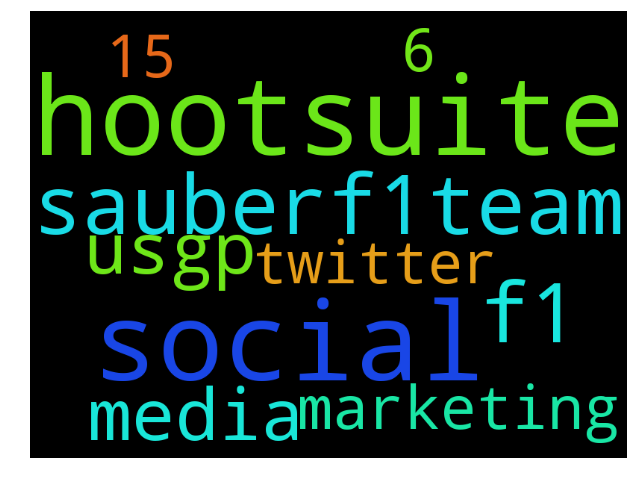

In [9]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)


## Most dominating topics - 2 clusters

Topic #0:
375.0: hootsuite
241.3: social
172.1: media
140.1: f1
139.4: sauberf1team
133.8: usgp
100.3: 6
87.1: 15
80.6: marketing
78.4: fp2
67.7: time
64.3: thanks
63.5: create
61.9: easy
61.7: fp1
60.6: million
59.6: strong
57.5: customers
56.9: —
54.7: plan

Topic #1:
198.1: hootsuite
53.4: sauberf1team
44.5: usgp
44.2: f1
43.0: 10
40.0: brands
38.5: 3
35.0: facebook
34.4: ready
34.2: getting
31.6: use
30.6: twitter
28.3: snapchat
27.8: good
27.5: make
25.4: works
24.8: really
24.5: like
24.0: hootdogs
24.0: howl-o-ween



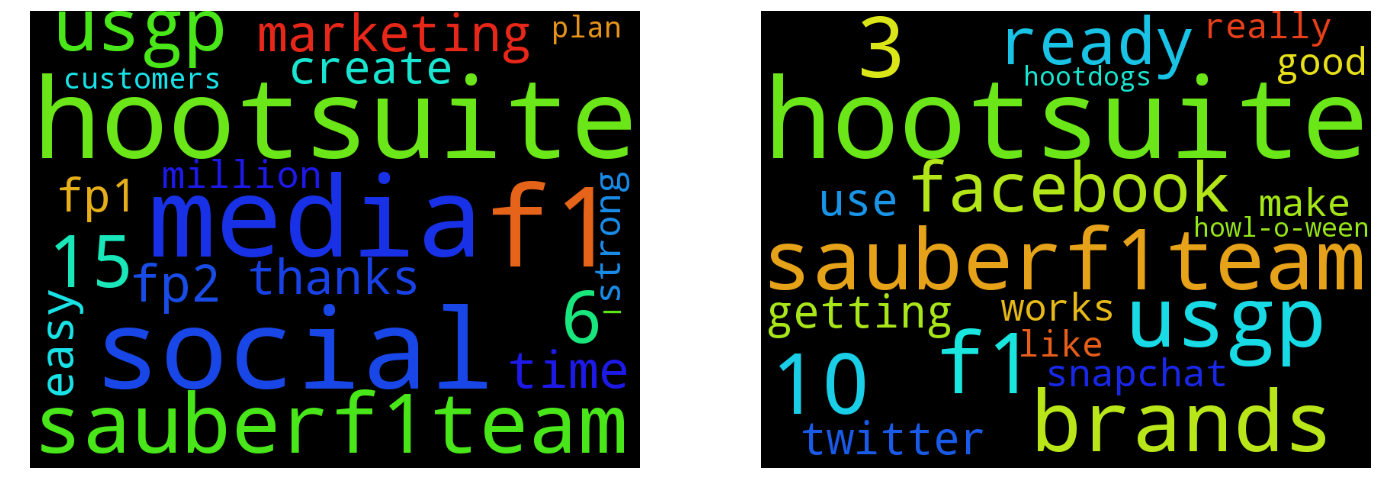

In [10]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters

Topic #0:
232.7: hootsuite
153.8: f1
150.6: sauberf1team
145.8: usgp
78.9: fp2
74.5: social
74.5: media
71.8: fp1
69.6: twitter
67.4: time
64.2: thanks
60.4: million
59.5: 15
59.5: strong
57.1: customers
54.6: we're
53.7: bag
53.7: win
53.6: —
52.8: fans

Topic #1:
85.5: hootsuite
42.9: 10
41.5: sauberf1team
32.1: usgp
30.2: f1
24.3: works
23.5: business
23.0: snapchat
22.1: figured
22.1: https://t.co/wqwibioh1q
22.1: 👌
22.1: https://t.co/aeqmpwd269
22.0: brands
22.0: periscope
21.4: it's
21.1: help
19.9: weekend
18.7: use
18.3: 3
17.9: lmp

Topic #2:
255.0: hootsuite
167.3: social
97.0: media
73.8: marketing
63.4: create
61.7: easy
55.4: guide
54.5: plan
51.1: 6
37.7: steps
35.0: https://t.co/n2gjos9wlc
35.0: https://t.co/zmmldvoauu
34.2: ready
34.0: getting
33.6: make
31.5: right
28.6: images
28.5: follow
27.9: step
27.8: https://t.co/cizqzslf7z



(0.0, 1.0, 0.0, 1.0)

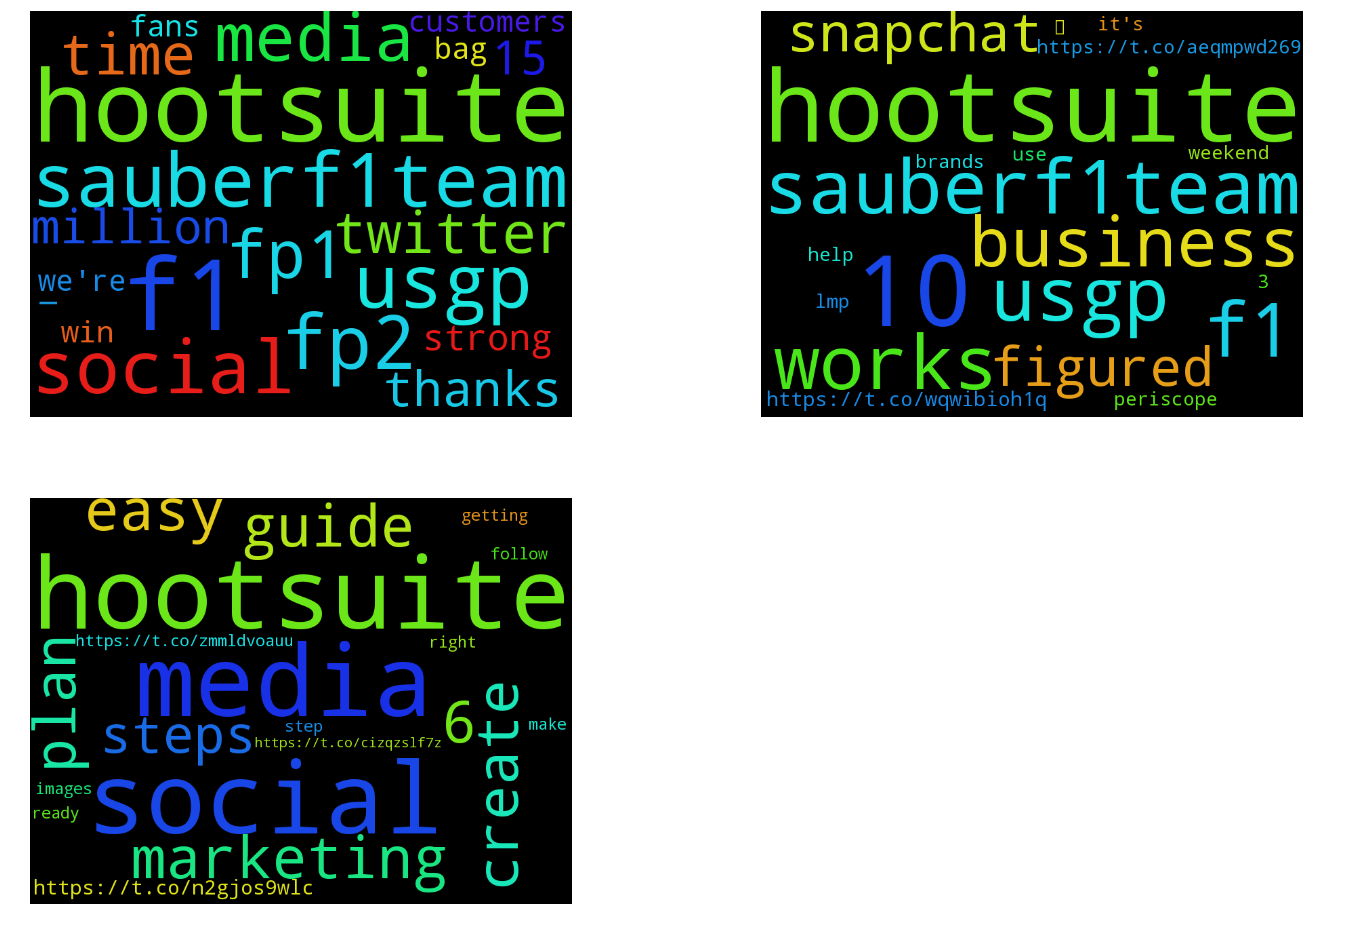

In [11]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters

Topic #0:
167.3: hootsuite
69.2: twitter
64.2: thanks
62.0: f1
60.3: million
59.4: strong
57.2: customers
56.6: —
55.0: 15
54.7: usgp
54.6: we're
53.6: bag
53.6: win
53.2: sauberf1team
52.7: fans
52.7: fill
52.7: chance
52.7: duffel
52.7: ambassadors
49.8: marcus

Topic #1:
139.1: sauberf1team
123.1: usgp
121.7: f1
61.2: fp1
40.3: hootsuite
34.8: fp2
29.6: me9
28.6: track
26.3: go
25.1: back
24.5: fn12
24.0: degrees
23.9: 10
22.8: good
22.2: min
22.1: snapchat
22.0: figured
22.0: https://t.co/wqwibioh1q
22.0: 👌
22.0: https://t.co/aeqmpwd269

Topic #2:
109.1: hootsuite
38.3: 3
34.1: ready
33.9: getting
31.0: facebook
29.9: make
24.7: really
24.3: like
23.8: tb
23.8: hootdogs
23.8: https://t.co/bagztg2hpi
23.8: https://t.co/enkoj9rapc
23.8: hoothalloween
23.8: 🐶
23.8: howl-o-ween
23.2: 1
20.6: ways
20.5: accounts
20.2: brands
19.1: 10

Topic #3:
256.3: hootsuite
233.9: social
166.8: media
100.7: marketing
100.1: 6
63.3: create
61.6: easy
54.4: plan
43.3: guide
39.9: help
38.1: using
37.6

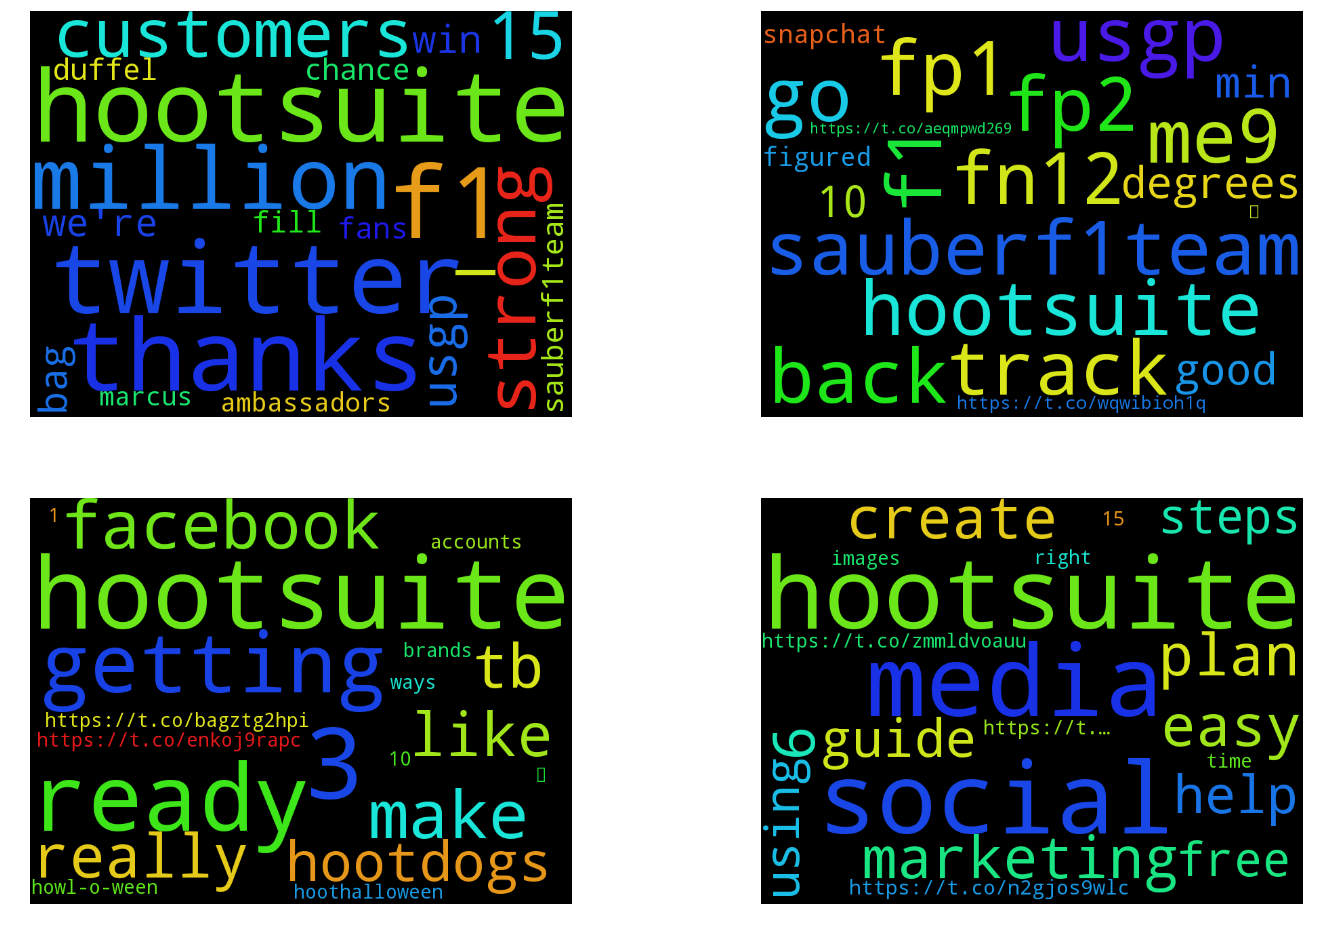

In [12]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [13]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_en)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)
co_occurrences.shape

(1918, 1918)

In [14]:
vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.head()

,0,1,2,3,4,5,6,7,8,9,...,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917
word,,,,,,,,,,,,,,,,,,,,,
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
..,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
co_occurrences.columns = vocab
co_occurrences.head()

,%,):,.,..,034,08450519390,1,1.2,10,11,...,😊,😍,😏,😔,😱,🙂,🙄,🙌,🚫,🤔
word,,,,,,,,,,,,,,,,,,,,,
%,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
):,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
..,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
034,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
def get_co_occurrences(df, word, n):
    coocs = df.loc[word]
    sorted = coocs.sort_values(ascending = False)
    return sorted[:n]

def plot_co_occurrences(word, coocs):
    plt.figure(figsize = (12, 8))
    plt.ylabel('number of co-occurrences')
    plt.title('Co-occurrences for: {}'.format(word))
    coocs.plot(kind='bar', color = colors, alpha = 0.2)
    plt.show()
    
words = ['oracle', 'microsoft', 'talend', 'bigdata', 'cloud']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)


KeyError: 'the label [oracle] is not in the [index]'

# Tweets in German

In [ ]:
tweets_german = pd.read_csv(german_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_german['text_wo_#'] = tweets_german['text_processed'].apply(lambda x: remove_hash(x))
tweets_german['text_wo_#@'] = tweets_german['text_wo_#'].apply(lambda x: remove_at(x))

X_train_de = tweets_german['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("german"))
stopwords_nltk
#relevant_words = set(['aber', 'nicht', 'nichts', 'ohne', 'nur', 'sehr', 'sollte', 'viel'])
relevant_words = set()
additional_stopwords = set([''])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [ ]:
X_train_de[-10:]

In [ ]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)
feature_names = vectorizer.get_feature_names()

In [ ]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - German

In [ ]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - German

In [ ]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - German

In [ ]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - German

In [ ]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [ ]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_de)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab

words = ['java', 'sap']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)

# Tweets in French

In [ ]:
tweets_french = pd.read_csv(french_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})
    
tweets_french['text_wo_#'] = tweets_french['text_processed'].apply(lambda x: remove_hash(x))
tweets_french['text_wo_#@'] = tweets_french['text_wo_#'].apply(lambda x: remove_at(x))

X_train_fr = tweets_french['text_wo_#@'].apply(lambda x: ' '.join(x))

stopwords_nltk = set(stopwords.words("french"))
stopwords_nltk
relevant_words = set([])

additional_stopwords = set(['les'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [ ]:
X_train_fr[-10:]

In [ ]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)
feature_names = vectorizer.get_feature_names()

In [ ]:
lda_models = []
for n_topics in range(1,5):    
    lda = LatentDirichletAllocation(n_topics = n_topics, random_state=0)
    lda.fit(words_matrix)
    lda_models.append(lda)

## Most dominating topics - overall - French

In [ ]:
model = lda_models[0]
n_top_words = 10
print_top_words(model, n_top_words)

fig, ax1 = plt.subplots(figsize = (12, 8))
axes = [ax1]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 2 clusters - French

In [ ]:
model = lda_models[1]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (24,16))
axes = [ax1, ax2]
show_word_clouds(model, axes, n_top_words)

## Most dominating topics - 3 clusters - French

In [ ]:
model = lda_models[2]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3]
show_word_clouds(model, axes, n_top_words)
ax4.axis('off')

## Most dominating topics - 4 clusters - French

In [ ]:
model = lda_models[3]
n_top_words = 20  
print_top_words(model, n_top_words)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (24,16))
axes = [ax1, ax2, ax3, ax4]
show_word_clouds(model, axes, n_top_words)

In [ ]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = str.split, 
                                    stop_words = stopwords_filtered, max_features = 100000, ngram_range = (1,1))
words_matrix = vectorizer.fit_transform(X_train_fr)

co_occurrence_matrix = words_matrix.T * words_matrix
co_occurrence_matrix.setdiag(0) 
array = co_occurrence_matrix.toarray()
co_occurrences = pd.DataFrame(array)

vocab = vectorizer.get_feature_names()
co_occurrences['word'] = vocab
co_occurrences = co_occurrences.set_index('word')
co_occurrences.columns = vocab
co_occurrences.head()

words = ['oracle', 'microsoft']    
n = 12
colors = 'cbgm'

for w in words: 
    coocs = get_co_occurrences(co_occurrences, w, n)
    print('Co-occurrences for: {}\n{}\n\n'.format(w, coocs))
    plot_co_occurrences(w, coocs)